In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modelbase.ode import Model, Simulator

In [2]:
def influx(kf):
    return kf


def outflux(s, kf):
    return s * kf


def proportional_1s_1p(s, p, keq):
    return s - p / keq


def mass_action_1s_1p(s, p, kf, keq):
    return kf * (s - p / keq)


def michaelis_menten_1s_1p(s1, p1, vmax, kms, kmp, keq):
    return vmax / kms * (s1 - p1 / keq) / (1 + s1 / kms + p1 / kmp)

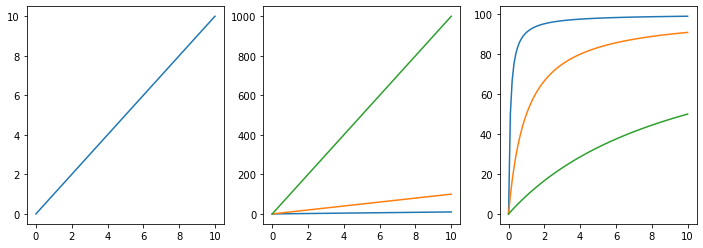

In [3]:
s = np.linspace(0, 10, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.plot(s, proportional_1s_1p(s, 0, 1))

ax2.plot(s, mass_action_1s_1p(s, 0, 1, 1))
ax2.plot(s, mass_action_1s_1p(s, 0, 10, 1))
ax2.plot(s, mass_action_1s_1p(s, 0, 100, 1))

ax3.plot(s, michaelis_menten_1s_1p(s, 0, 100, 0.1, 1, 1))
ax3.plot(s, michaelis_menten_1s_1p(s, 0, 100, 1, 1, 1))
ax3.plot(s, michaelis_menten_1s_1p(s, 0, 100, 10, 1, 1))
plt.show()

# Simple model

`-> A <-> B <-> C ->`

Assume that the correct kinetics are michaelis-menten. What happens, if we model this with either
- kinetics proportional to concentration + keq
- mass-action kinetics
- michaelis-menten kinetics
    
but we **have the wrong parameters**?

In [4]:
default_pars = {
    "k_in": 0.1,
    "keq_ab": 2,
    "keq_bc": 5,
    "k_out": 1,
}


def get_proportional_model():
    m = Model()
    m.add_compounds(["A", "B", "C"])
    m.add_parameters(default_pars)
    m.add_reaction("v_in", influx, {"A": 1}, parameters=["k_in"])
    m.add_reaction(
        "v_ab",
        proportional_1s_1p,
        {"A": -1, "B": 1},
        parameters=["keq_ab"],
        reversible=True,
    )
    m.add_reaction(
        "v_bc",
        proportional_1s_1p,
        {"B": -1, "C": 1},
        parameters=["keq_bc"],
        reversible=True,
    )
    m.add_reaction("v_out", outflux, {"C": -1}, parameters=["k_out"])
    return m


def get_ma_model(kf1, kf2):
    m = Model()
    m.add_compounds(["A", "B", "C"])
    m.add_parameters(
        default_pars
        | {
            "kf_a": kf1,
            "kf_b": kf2,
        }
    )
    m.add_reaction("v_in", influx, {"A": 1}, parameters=["k_in"])
    m.add_reaction(
        "v_ab",
        mass_action_1s_1p,
        {"A": -1, "B": 1},
        parameters=["kf_a", "keq_ab"],
        reversible=True,
    )
    m.add_reaction(
        "v_bc",
        mass_action_1s_1p,
        {"B": -1, "C": 1},
        parameters=["kf_b", "keq_bc"],
        reversible=True,
    )
    m.add_reaction("v_out", outflux, {"C": -1}, parameters=["k_out"])
    return m


def get_mm_model(vmax1, vmax2, km1, km2):
    m = Model()
    m.add_compounds(["A", "B", "C"])
    m.add_parameters(
        default_pars
        | {
            "vmax_ab": vmax1,
            "vmax_bc": vmax2,
            "km_a": km1,
            "km_b": km2,
            "km_r": 1,
        }
    )
    m.add_reaction("v_in", influx, {"A": 1}, parameters=["k_in"])
    m.add_reaction(
        "v_ab",
        michaelis_menten_1s_1p,
        {"A": -1, "B": 1},
        parameters=["vmax_ab", "km_a", "km_r", "keq_ab"],
        reversible=True,
    )
    m.add_reaction(
        "v_bc",
        michaelis_menten_1s_1p,
        {"B": -1, "C": 1},
        parameters=["vmax_bc", "km_b", "km_r", "keq_bc"],
        reversible=True,
    )
    m.add_reaction("v_out", outflux, {"C": -1}, parameters=["k_out"])
    return m

In [6]:
def plot_errors(vals, error_pr, error_ma, error_mm, title):
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, subplot_kw={"projection": "3d"}, figsize=(18, 5)
    )
    z_max = max(np.max(error_pr), np.max(error_ma), np.max(error_mm))
    X, Y = np.meshgrid(vals, vals)
    ax1.plot_surface(X, Y, error_pr.T, cmap="viridis", vmin=0, vmax=z_max)
    ax1.set(
        title="Proportional",
        zlim=(0, z_max * 1.1),
        xlabel="Vmax Real",
        ylabel="",
        zlabel="Relative error",
    )
    ax2.plot_surface(X, Y, error_ma.T, cmap="viridis", vmin=0, vmax=z_max)
    ax2.set(
        title="Mass action",
        zlim=(0, z_max * 1.1),
        xlabel="Vmax Real",
        ylabel="kf Estimate",
        zlabel="Relative error",
    )
    ax3.plot_surface(X, Y, error_mm.T, cmap="viridis", vmin=0, vmax=z_max)
    ax3.set(
        title="Michaelis Menten",
        zlim=(0, z_max * 1.1),
        xlabel="Vmax Real",
        ylabel="Vmax Estimate",
        zlabel="Relative error",
    )
    fig.suptitle(title, fontsize=16)

    for ax in (ax1, ax2, ax3):
        ax.view_init(30, 135)  # default 30, -60
    fig.tight_layout()
    return fig, (ax1, ax2, ax3)

In [7]:
def get_errors_same_vmax(vmax_real, vmax_estimate, km):
    m = get_mm_model(vmax1=vmax_real, vmax2=vmax_real, km1=km, km2=km)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, real = s.simulate_to_steady_state()

    m = get_proportional_model()
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, pr = s.simulate_to_steady_state()
    if pr is None:
        pr = 0

    m = get_ma_model(kf1=vmax_estimate, kf2=vmax_estimate)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, ma = s.simulate_to_steady_state()
    if ma is None:
        ma = 0

    m = get_mm_model(vmax1=vmax_estimate, vmax2=vmax_estimate, km1=km, km2=km)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, mm = s.simulate_to_steady_state()
    if mm is None:
        mm = 0
    # return np.log(pr / real), np.log(ma / real), np.log(mm / real)
    return (real - pr) / real, (real - ma) / real, (real - mm) / real


def experiment1(vmax_min, vmax_max, km, title="", n=10):
    error_pr = np.full((n, n), 0, dtype=float)
    error_ma = np.full((n, n), 0, dtype=float)
    error_mm = np.full((n, n), 0, dtype=float)
    vals = np.geomspace(vmax_min, vmax_max, n)
    for i, vmax_real in enumerate(vals):
        for j, vmax_estimate in enumerate(vals):
            e_pr, e_ma, e_mm = get_errors_same_vmax(vmax_real, vmax_estimate, km)
            error_pr[i, j] = np.sum(np.abs(e_pr))
            error_ma[i, j] = np.sum(np.abs(e_ma))
            error_mm[i, j] = np.sum(np.abs(e_mm))
    return plot_errors(vals, error_pr, error_ma, error_mm, title)

# Case 1

Both reactions A <-> B and B <-> C have the *same* vmax values

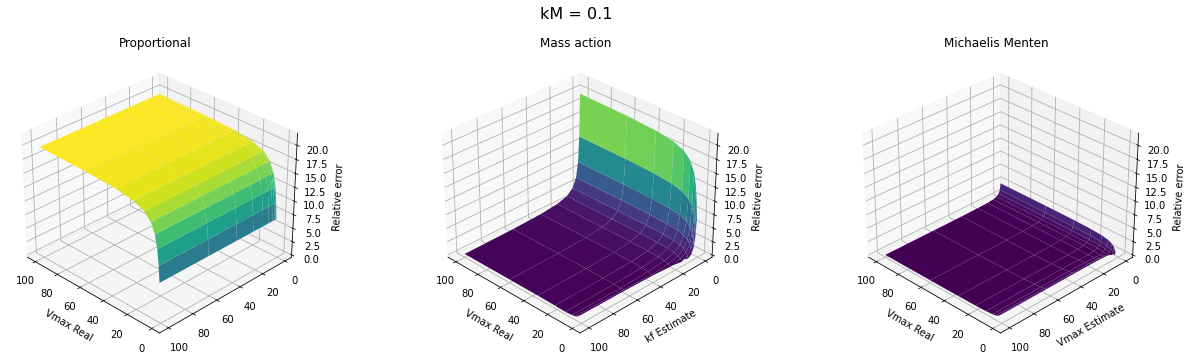

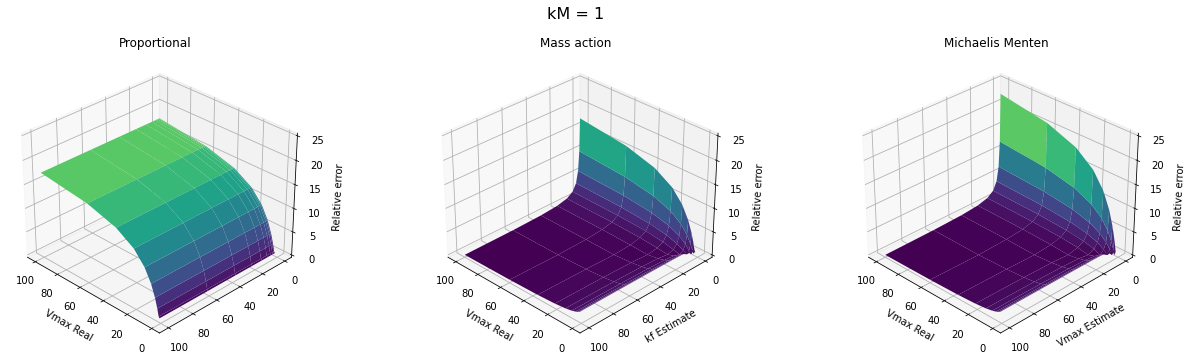

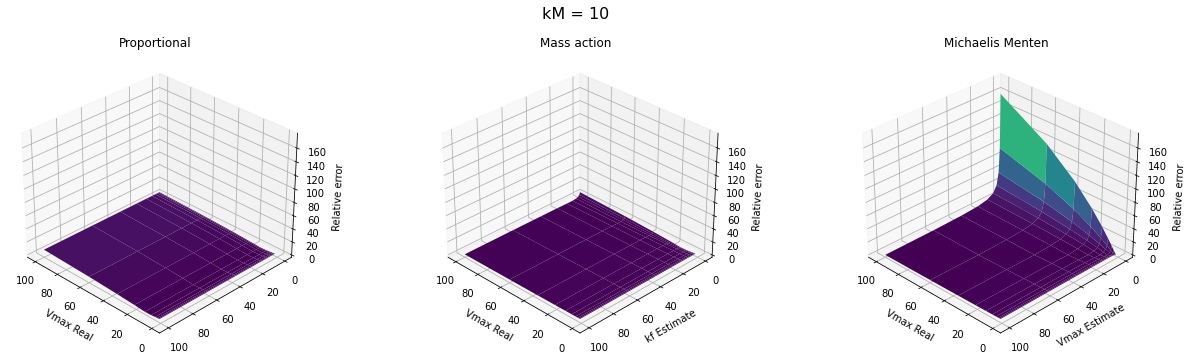

In [8]:
experiment1(vmax_min=1, vmax_max=100, km=0.1, title=f"kM = {0.1}")
experiment1(vmax_min=1, vmax_max=100, km=1, title=f"kM = {1}")
experiment1(vmax_min=1, vmax_max=100, km=10, title=f"kM = {10}")
plt.show()

In [ ]:
def get_errors_different_vmax(vmax1_real, vmax1_estimate, vmax2, km):
    m = get_mm_model(vmax1=vmax1_real, vmax2=vmax2, km1=km, km2=km)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, real = s.simulate_to_steady_state()

    m = get_proportional_model()
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, pr = s.simulate_to_steady_state()
    if pr is None:
        pr = 0

    m = get_ma_model(kf1=vmax1_estimate, kf2=vmax2)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, ma = s.simulate_to_steady_state()
    if ma is None:
        ma = 0

    m = get_mm_model(vmax1=vmax1_estimate, vmax2=vmax2, km1=km, km2=km)
    s = Simulator(m)
    s.initialise({"A": 0, "B": 0, "C": 0})
    _, mm = s.simulate_to_steady_state()
    if mm is None:
        mm = 0
    return (real - pr) / real, (real - ma) / real, (real - mm) / real


def experiment2(vmax1_min, vmax1_max, vmax2, km, title, n=10):
    error_mm = np.full((n, n), 0, dtype=float)
    error_ma = np.full((n, n), 0, dtype=float)
    error_pr = np.full((n, n), 0, dtype=float)
    vals = np.geomspace(vmax1_min, vmax1_max, n)
    for i, vmax1_real in enumerate(vals):
        for j, vmax1_estimate in enumerate(vals):
            e_pr, e_ma, e_mm = get_errors_different_vmax(
                vmax1_real, vmax1_estimate, vmax2, km
            )
            error_pr[i, j] = np.sum(np.abs(e_pr))
            error_ma[i, j] = np.sum(np.abs(e_ma))
            error_mm[i, j] = np.sum(np.abs(e_mm))
    return plot_errors(vals, error_pr, error_ma, error_mm, title)

# Case 2

The reactions A <-> B and B <-> C have *different* vmax values

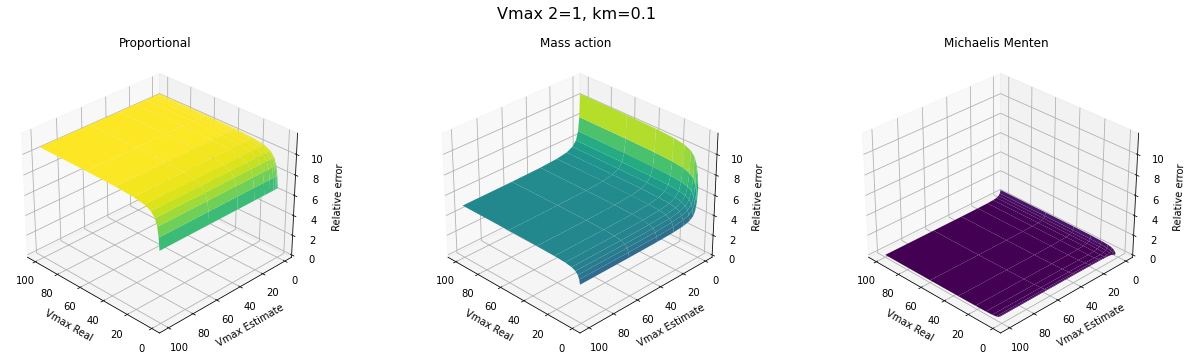

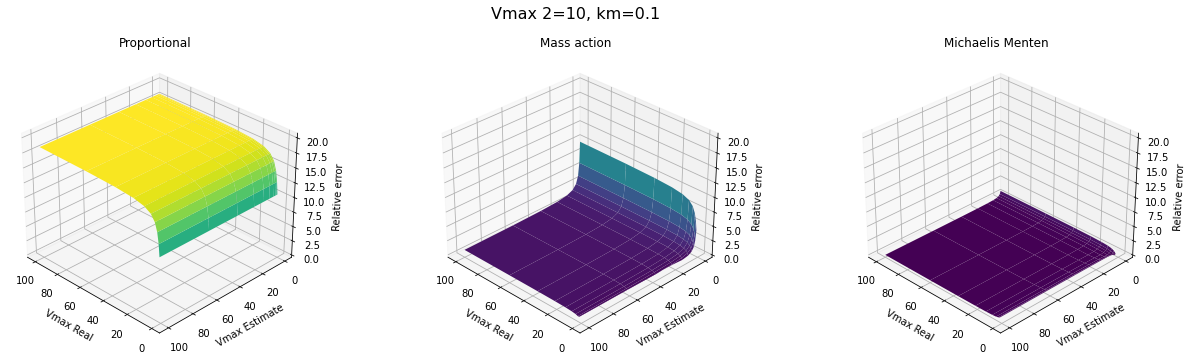

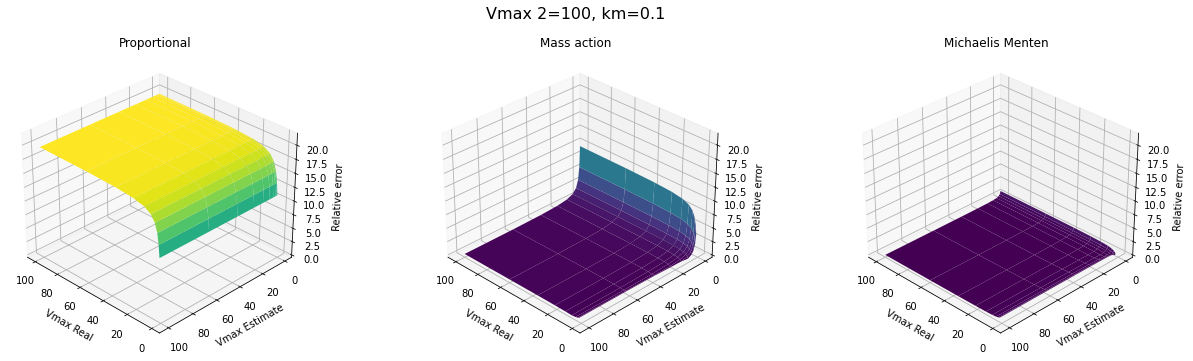

In [9]:
experiment2(1, 100, vmax2=1, km=0.1, title="Vmax 2=1, km=0.1")
experiment2(1, 100, vmax2=10, km=0.1, title="Vmax 2=10, km=0.1")
experiment2(1, 100, vmax2=100, km=0.1, title="Vmax 2=100, km=0.1")
plt.show()

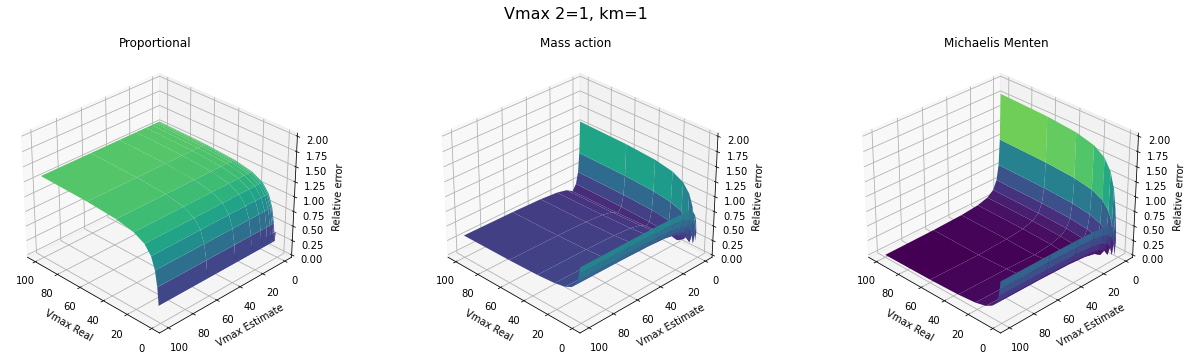

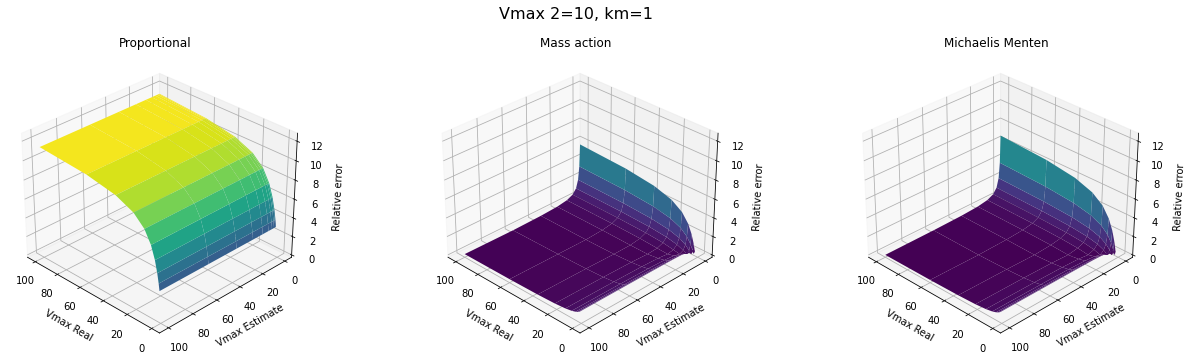

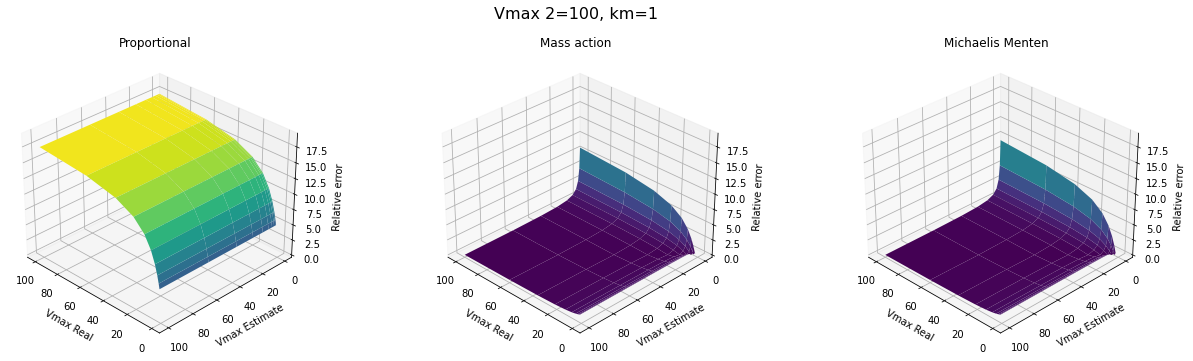

In [10]:
experiment2(1, 100, vmax2=1, km=1, title="Vmax 2=1, km=1")
experiment2(1, 100, vmax2=10, km=1, title="Vmax 2=10, km=1")
experiment2(1, 100, vmax2=100, km=1, title="Vmax 2=100, km=1")
plt.show()

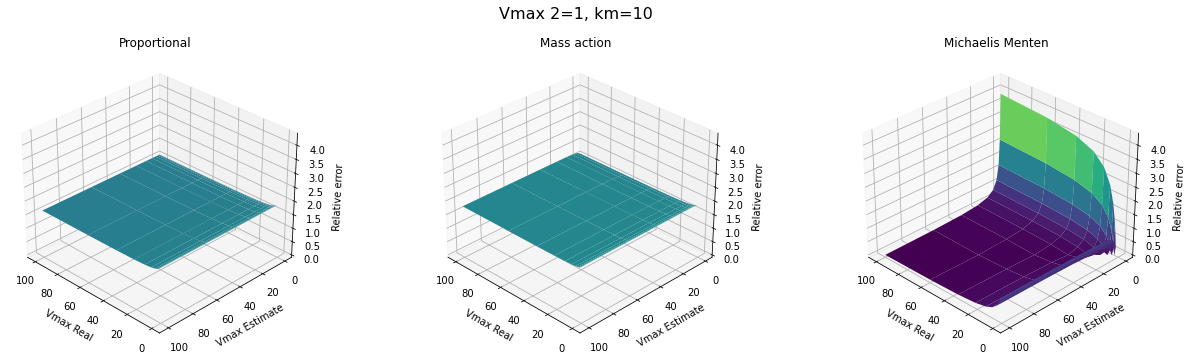

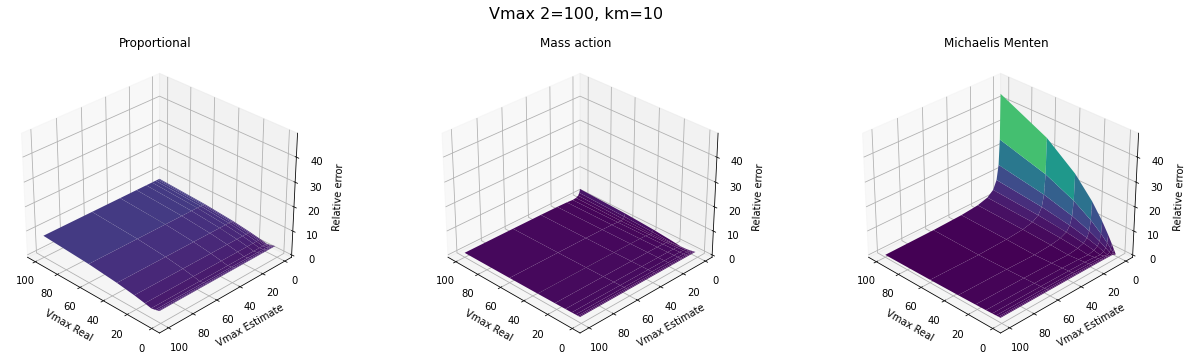

In [11]:
experiment2(1, 100, vmax2=1, km=10, title="Vmax 2=1, km=10")
experiment2(1, 100, vmax2=10, km=10, title="Vmax 2=10, km=10")
experiment2(1, 100, vmax2=100, km=10, title="Vmax 2=100, km=10")
plt.show()